# Производительность воркера на GPU с **whisper** по сравнению с CPU-воркерами на Vosk

In [1]:
import warnings
import pandas as pd
import pymssql

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
            tds_version=r'7.0'
    )

In [3]:
def read_sql(query):
    return pd.read_sql_query(query, con=ms_sql_con(), parse_dates=None)

In [4]:
def perfomance_by_cpu(start_date, end_date):
    query = "select file_name, cpu, step, time, duration"
    query += " from perf_log "
    query += " where event_date > '"+start_date+"'"
    query += " and event_date < '"+end_date+"'"
    query += " and step = 2;"

    df = read_sql(query)
    df['td'] = df.time/df.duration

    if len(df):
        df.groupby('cpu').count().plot(
            y = ['file_name'], 
            kind="bar",
            width=.8,
            figsize=(20, 6),
            ylabel='Количество файлов', 
            title='Транскрибация аудиофайлов по воркерам',
            legend=False
        )

        gpu_min = df['duration'].sum() / 60
        gpu_h = gpu_min / 60
        df.drop(['file_name', 'time', 'duration'], axis=1, inplace = True)

        df.groupby('cpu').median().plot(
            y = ['td'], 
            kind="bar",
            width=.8,
            figsize=(20, 6),
            ylabel='Производительность', 
            title='Медианная производительность транскрибации',
            legend=False
        )
    print(f'Общее количество распознанных аудиофайлов: {len(df)}')
    print(f'Суммарная длительность записей, распознанных Whisper: {round(gpu_min)} мин ({round(gpu_h)} ч)')

Общее количество распознанных аудиофайлов: 7768
Суммарная длительность записей, распознанных Whisper: 11918 мин (199 ч)


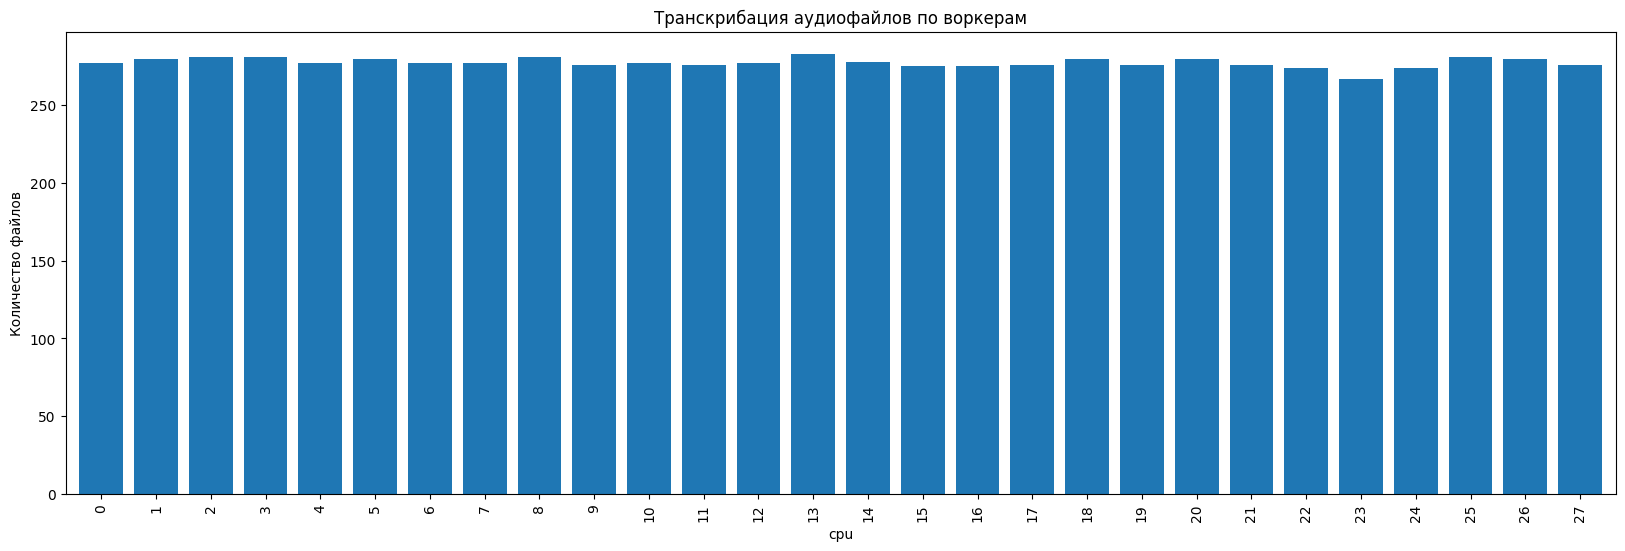

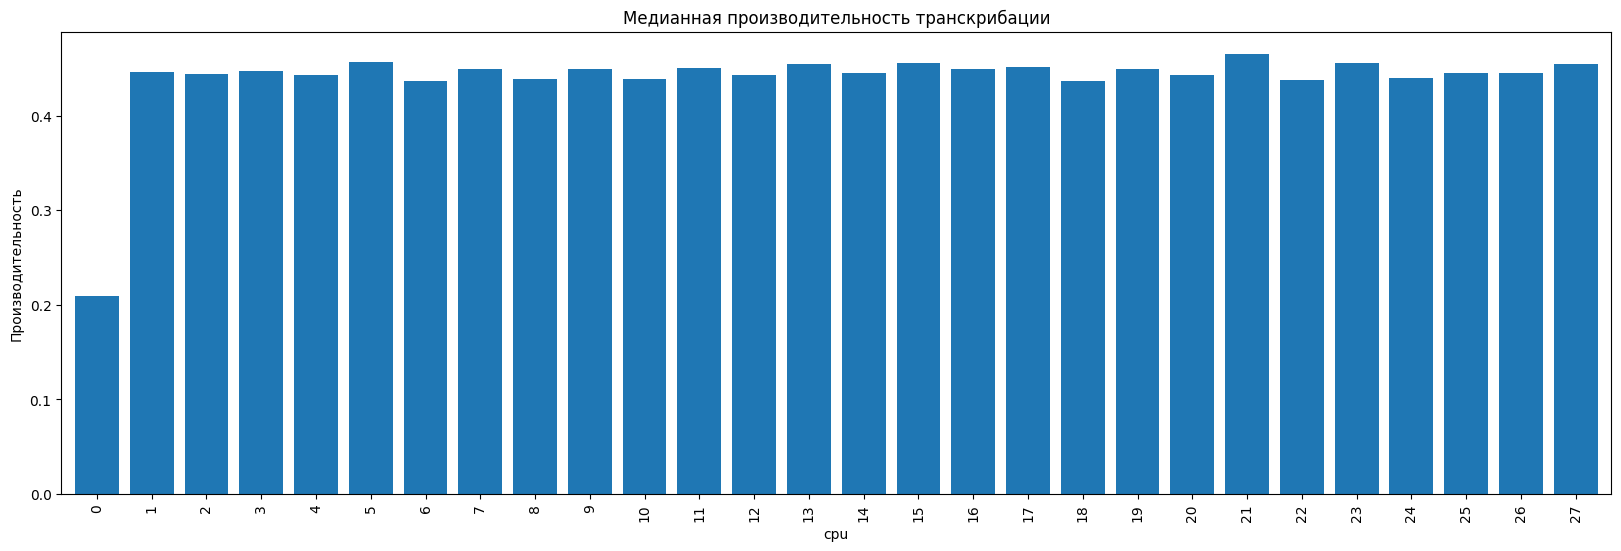

In [5]:
start_date = '2024-02-06 15:00:00'
end_date = '2024-02-06 21:00:00'
perfomance_by_cpu(start_date, end_date)

In [6]:
query = '''
SELECT CAST(transcribation_date AS DATE),
       whisper,
       conf,
       linkedid,
       audio_file_name
FROM transcribations
WHERE CAST(transcribation_date AS DATE) BETWEEN '2024-02-06' AND '2024-02-06'
AND whisper=1;
'''

df = read_sql(query).drop_duplicates(
    subset=['linkedid', 'audio_file_name']
)
print(
    f'Средняя уверенность в распознанном тексте: {round(df.conf.mean(), 3)}'
)

Средняя уверенность в распознанном тексте: 0.766
